In [1]:
import os
import re
import json

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd
import torch

In [2]:
REF_POINT = torch.Tensor([-10, -10])
device = "cpu"

In [3]:
def load_json_res(pcc, data_dir):
    with open(f"{data_dir}/{pcc}_FEN.JSON") as f:
        rep = json.load(f)
    F_fen = rep["FE"]
    F_fen_err = rep["FE_error"]

    with open(f"{data_dir}/{pcc}_DEC.JSON") as f:
        rep = json.load(f)
    F_dec = rep["FE"]
    F_dec_err = rep["FE_error"]
    return {"PCC": [rep["PCC"]], "F_FEN": [float(F_fen)], "err_FEN": [float(F_fen_err)],
             "F_DEC": [float(F_dec)], "err_DEC": [float(F_dec_err)]}

def load_data(data_dir):
    PCC_list = []
    for folder in os.listdir(data_dir):
        if re.match("[A-Z]{5}_[A-Z]{3}", folder):
            PCC_list.append(folder.split("_")[0])

    PCC_list = set(PCC_list)
    data = []
    for pcc in PCC_list:
        try:
            data.append(pd.DataFrame(load_json_res(pcc, data_dir)))
        except:
            print(f"Skipping {pcc}.")

    data = pd.concat(data)
    data.reset_index(inplace=True, drop=True)
    return data

In [4]:
dataset_raw = load_data("../MD_results")
dataset = dataset_raw.copy()
dataset["ddG_sen"] = -1*dataset.F_FEN
dataset["ddG_spe"] = dataset.F_DEC-dataset.F_FEN
dataset["sen_err"] = dataset.err_FEN
dataset["spe_err"] = np.sqrt(dataset.err_FEN**2 + dataset.err_DEC**2)
sen_transform = [dataset.ddG_sen.mean(), dataset.ddG_sen.std()]
spe_transform = [dataset.ddG_spe.mean(), dataset.ddG_spe.std()]
dataset.sen_err = dataset.sen_err/dataset.ddG_sen.std()
dataset.ddG_sen = (dataset.ddG_sen - dataset.ddG_sen.mean())/dataset.ddG_sen.std()
dataset.spe_err = dataset.spe_err/dataset.ddG_spe.std()
dataset.ddG_spe = (dataset.ddG_spe - dataset.ddG_spe.mean())/dataset.ddG_spe.std()

In [5]:
FE_sen = torch.tensor(dataset.ddG_sen.to_numpy()).float().to(device)
FE_sen_err = torch.tensor(dataset.sen_err.to_numpy()).float().to(device)
FE_spe = torch.tensor(dataset.ddG_spe.to_numpy()).float().to(device)
FE_spe_err = torch.tensor(dataset.spe_err.to_numpy()).float().to(device)
train_y = torch.cat([FE_sen.view(-1, 1), FE_spe.view(-1, 1)], dim=1)
err_y = torch.cat([FE_sen_err.view(-1, 1), FE_spe_err.view(-1, 1)], dim=1)

In [6]:
qNEHVI_data = {"1" : ["HYWWY", "HWWLY", "HWHWW"],
               "2" : ['NHWWW', 'HNWWW', 'HWWWT'],
               "3" : ['HWWTW', 'HGWWW', 'HWWWV'], 
               "4" : ['HGWWV', 'GWWTW', 'HWTWW'],
               "5" : ['HWWTV', 'HPWWW', 'HWWWL'],
               "6" : ['HGHWW', 'HGWYW', 'HGWVW'],
               "7" : ['WHWWV', 'HWWWA', 'TWWWV'],
               "8" : ['HWGHY', 'HWWWY', 'HWWWF'],
               "9" : ['HWYWT', 'HWGWW', 'YGWWW'],
               "10": ['HYGWW', 'YGWWT', 'YGWWE'],
               "11": ['WGWWW', 'FGWWW', 'PGWWW'],
               "12": ['WWGWY', 'YGFWW', 'YWGAW'],
               "13": ['YSAWW', 'YSWWW', 'NSAWW'],
               "14": ['HWAWY', 'YGAWW', 'LSAWY'],
               "15": ['YGVWW', 'LGAWW', 'YNAWW'],
               "16": ['YNAYY', 'YNANY', 'YNAHT'],
               "17": ['YTYHT', 'YTYKY', 'YTYVH'],
               "18": ['YTVHT', 'YGLHT', 'YYHHT'],
               "19": ['HFHNT', 'NFHVH', 'HTFHE'],
               "20": ['FTTGF', 'FTHGF', 'FTFGF'],
               
               }

qUCB_data = {"6" : ["VVVVE"],
                     "7" : ['HGGGG', 'AGGGF', 'HHGGF'],
                     "8" : ['TWTWW', 'FWTWW', 'GATWW'],
                     "9" : ['GGAGA', 'GHGAG', 'FGAAG'],
                     "10": ['GGAGG', 'GGANG', 'GGAWY'],
                     "11": ['GGADG', 'GAANG', 'AGANG'],
                     "12": ['GSANG', 'AAANG', 'GGVNG'],
                     "13": ['LGANG', 'GGANA', 'AGADG'],
                     "14": ['GGAGP', 'GGAGN', 'GGWPG'],
                     "15": ['GGAGD', 'GAAGG', 'GGAGW'],
                     "16": ['FGWWE', 'FTYWD', 'FTWWE'],
                     "17": ['GGAGS', 'GGNGP', 'GAGNG'],
                     "18": ['GGAGE', 'GGTGP', 'GGAGT'],
                     "19": ['GGAGY', 'GGAPY', 'YTLYP'],
                     "20": ['HHWTW', 'GFHVY', 'FHVPY'],
                     
               }

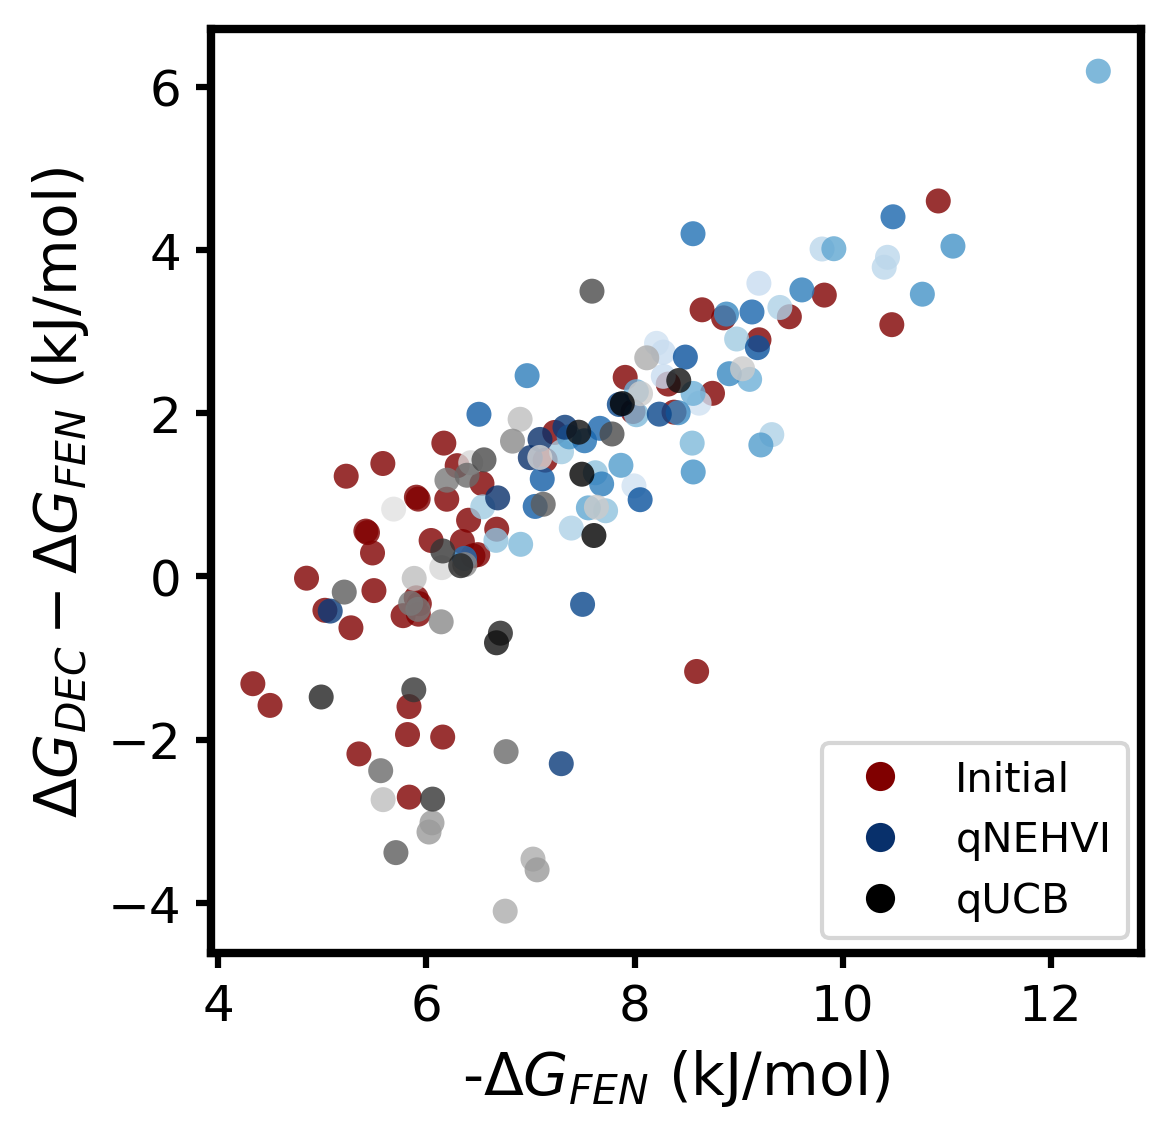

In [7]:
cmap = plt.get_cmap('Blues')
colors = [cmap(i) for i in np.linspace(0.2, 1, len(qNEHVI_data))]
cmap1 = LinearSegmentedColormap.from_list("custom_cmap1", list(zip(np.linspace(0.2, 1, len(qNEHVI_data)), colors)))

cmap2 = plt.get_cmap('Grays')
colors2 = [cmap2(i) for i in np.linspace(0.2, 1, len(qUCB_data))]
cmap2 = LinearSegmentedColormap.from_list("custom_cmap2", list(zip(np.linspace(0.2, 1, len(qUCB_data)), colors2)))

fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=300)

all_selected = [item for sublist in qNEHVI_data.values() for item in sublist] + \
               [item for sublist in qUCB_data.values() for item in sublist]
x_train = dataset[~dataset.PCC.isin(all_selected)].ddG_sen*sen_transform[1] + sen_transform[0]
y_train = dataset[~dataset.PCC.isin(all_selected)].ddG_spe*spe_transform[1] + spe_transform[0]
ax.scatter(x = x_train, y = y_train, color='#800000', edgecolors='none', alpha=0.8)

init_data = [i for i in dataset_raw.PCC.to_list() if i not in sum(list(qNEHVI_data.values()), [])]


for i, item in enumerate(qNEHVI_data.items()):
    round, cands = item
    r1_x_true = dataset[dataset.PCC.isin(cands)].ddG_sen*sen_transform[1] + sen_transform[0]
    r1_y_true = dataset[dataset.PCC.isin(cands)].ddG_spe*spe_transform[1] + spe_transform[0]
    ax.scatter(x = r1_x_true , y = r1_y_true, color=colors[i], edgecolors='none', alpha=0.8)

for i, item in enumerate(qUCB_data.items()):
    round, cands = item
    r1_x_true = dataset[dataset.PCC.isin(cands)].ddG_sen*sen_transform[1] + sen_transform[0]
    r1_y_true = dataset[dataset.PCC.isin(cands)].ddG_spe*spe_transform[1] + spe_transform[0]
    ax.scatter(x = r1_x_true , y = r1_y_true, color=colors2[i], edgecolors='none', alpha=0.8)

ax.set_xlabel(r"-$\Delta G_{FEN}$ (kJ/mol)", fontsize=14)
ax.set_ylabel(r"$\Delta G_{DEC}-\Delta G_{FEN}$ (kJ/mol)", fontsize=14)
ax.tick_params(axis="both", which='major', labelsize=12)
ax.xaxis.set_tick_params(width=1.5)
ax.yaxis.set_tick_params(width=1.5)



marker1 = Line2D([0], [0], color='#800000' , marker='o', linestyle='None')
marker2 = Line2D([0], [0], color=colors[-1] , marker='o', linestyle='None')
marker3 = Line2D([0], [0], color=colors2[-1], marker='o', linestyle='None')

ax.legend([marker1, marker2, marker3],
           ['Initial', 
            'qNEHVI',
            'qUCB',
           ],
           loc="upper left", bbox_to_anchor=(0.635, 0.25))


for side in ['top', 'bottom', 'left', 'right']:
    ax.spines[side].set(lw=2)
plt.show()

In [8]:
BO_rounds = {  "1" : ["HYWWY", "HWWLY", "HWHWW"],
               "2" : ['NHWWW', 'HNWWW', 'HWWWT'],
               "3" : ['HWWTW', 'HGWWW', 'HWWWV'], 
               "4" : ['HGWWV', 'GWWTW', 'HWTWW'],
               "5" : ['HWWTV', 'HPWWW', 'HWWWL'],
               "6" : ['HGHWW', 'HGWYW', 'HGWVW', 'VVVVE'],
               "7" : ['WHWWV', 'HWWWA', 'TWWWV', 'HGGGG', 'AGGGF', 'HHGGF'],
               "8" : ['HWGHY', 'HWWWY', 'HWWWF', 'TWTWW', 'FWTWW', 'GATWW'],
               "9" : ['HWYWT', 'HWGWW', 'YGWWW', 'GGAGA', 'GHGAG', 'FGAAG'],
               "10": ['HYGWW', 'YGWWT', 'YGWWE', 'GGAGG', 'GGANG', 'GGAWY'],
               "11": ['WGWWW', 'FGWWW', 'PGWWW', 'GGADG', 'GAANG', 'AGANG'],
               "12": ['WWGWY', 'YGFWW', 'YWGAW', 'GSANG', 'AAANG', 'GGVNG'],
               "13": ['YSAWW', 'YSWWW', 'NSAWW', 'LGANG', 'GGANA', 'AGADG'],
               "14": ['HWAWY', 'YGAWW', 'LSAWY', 'GGAGP', 'GGAGN', 'GGWPG'],
               "15": ['YGVWW', 'LGAWW', 'YNAWW', 'GGAGD', 'GAAGG', 'GGAGW'],
               "16": ['YNAYY', 'YNANY', 'YNAHT', 'FGWWE', 'FTYWD', 'FTWWE'],
               "17": ['YTYHT', 'YTYKY', 'YTYVH', 'GGAGS', 'GGNGP', 'GAGNG'],
               "18": ['YTVHT', 'YGLHT', 'YYHHT', 'GGAGE', 'GGTGP', 'GGAGT'],
               "19": ['HFHNT', 'NFHVH', 'HTFHE', 'GGAGY', 'GGAPY', 'YTLYP'],
               "20": ['FTTGF', 'FTHGF', 'FTFGF', 'HHWTW', 'GFHVY', 'FHVPY'],
               "21": []
               }

In [9]:
def calc_true_metric(dataset, round_n):
    dataset = dataset.copy()
    exclude_list = []
    rounds = [str(i) for i in BO_rounds.keys()]
    for _ in range(round_n):
        rounds.pop(0)
    for key in rounds:
        exclude_list += BO_rounds[key]

    
    dataset = dataset[~dataset.PCC.isin(exclude_list)]

    dataset["mixed"] = np.sqrt((dataset.ddG_sen-REF_POINT[0].item())**2 + (dataset.ddG_spe-REF_POINT[1].item())**2)
    res = {}

    res['all_data'] = torch.Tensor(dataset.mixed.to_numpy())
    res['top1'] = res['all_data'].max()
    res['top10'] = (res["all_data"].topk(10)[0]).mean()

    selected_ds = dataset[dataset.PCC.isin(BO_rounds[str(round_n)])]
    res['selected'] =torch.Tensor(selected_ds.mixed.to_numpy())

    return res

In [10]:
results = {}
for i in BO_rounds.keys():
    results[i] = calc_true_metric(dataset, int(i))

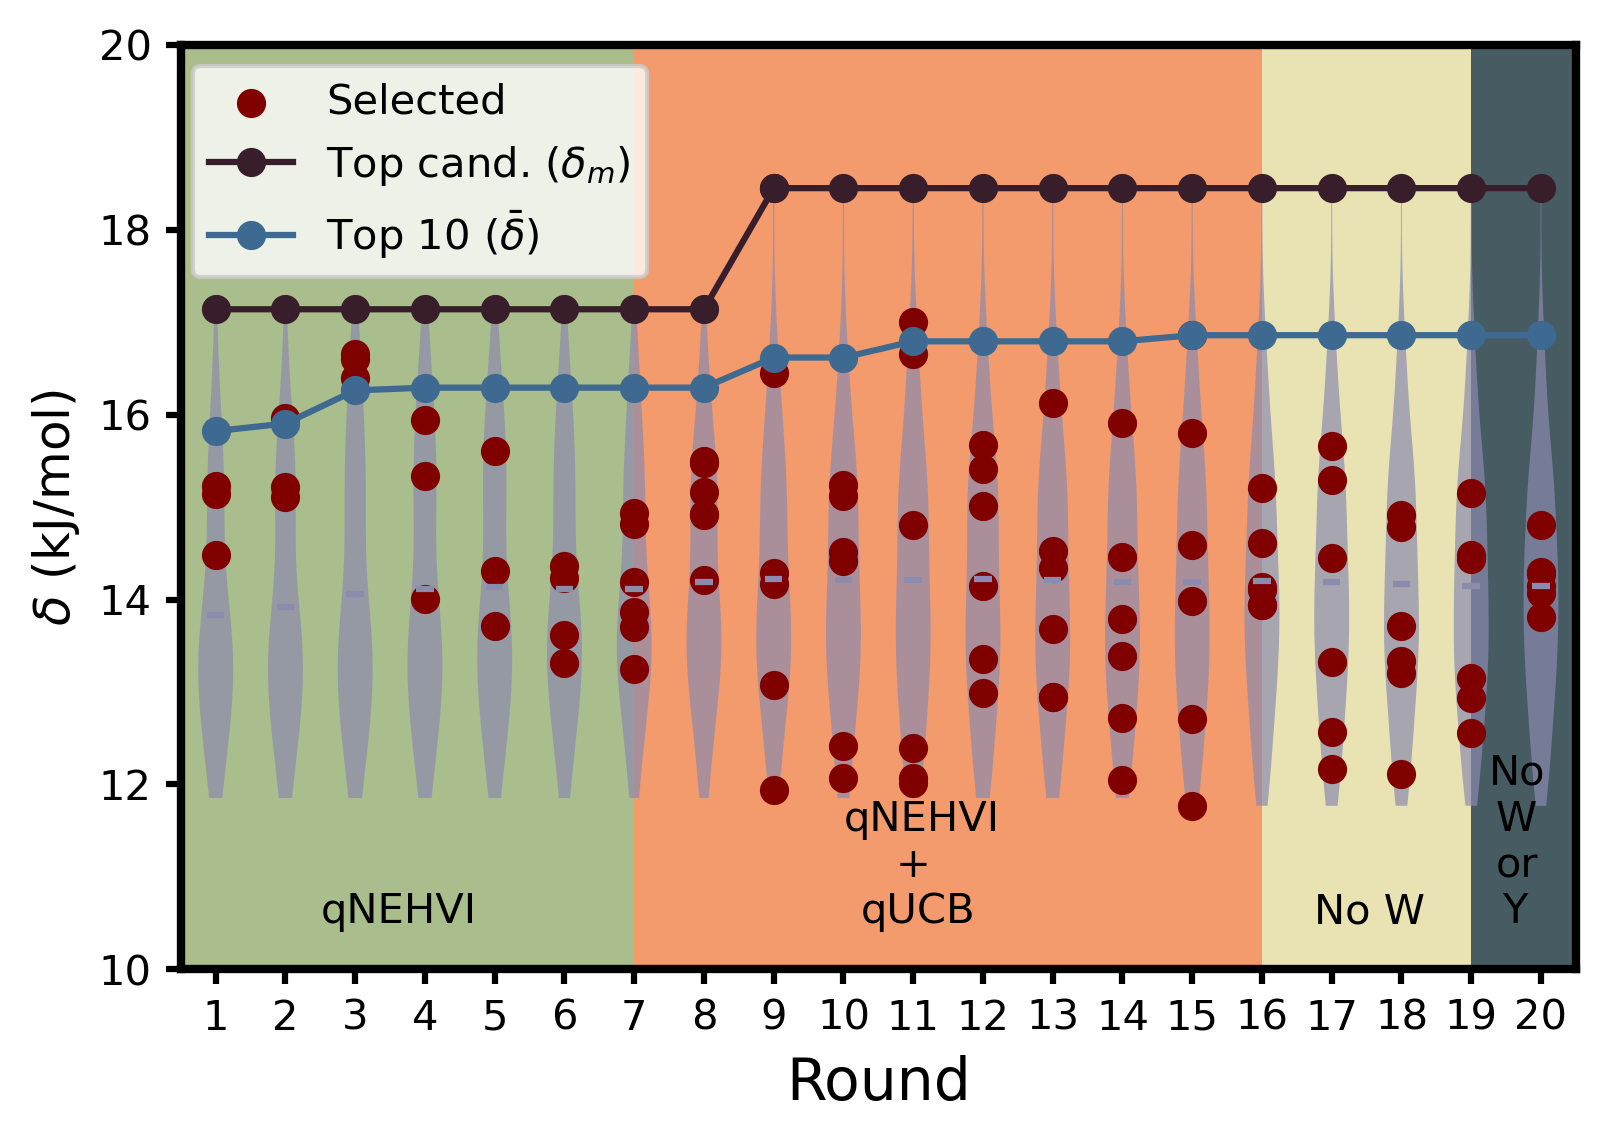

In [11]:
top_cand =  np.array([results[i]['top1'] for i in results.keys()])[:-1]
top_cands =  np.array([results[i]['top10'] for i in results.keys()])[:-1]
all_data = [results[i]['all_data'] for i in results.keys()][:-1]

fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)

c1 = mcolors.to_rgb("#AABD8C")
ax.axvspan(-1, 6, facecolor=c1, alpha=1)
c2 = mcolors.to_rgb("#E9E3B4")
ax.axvspan(15, 18, facecolor=c2, alpha=1)
c3 = mcolors.to_rgb("#F39B6D")
ax.axvspan(6, 15, facecolor=c3, alpha=1)
c4 = mcolors.to_rgb("#475B63")
ax.axvspan(18, 21, facecolor=c4, alpha=1)

xaxis_data = [i for i in range(len(BO_rounds))][:-1]
violin_parts = ax.violinplot(all_data, positions=xaxis_data, showmeans=True, showextrema=False)
for pc in violin_parts['bodies']:
    pc.set_facecolor('#8B8BAE')
    pc.set_alpha(0.7)

violin_parts['cmeans'].set_color('#8B8BAE')

for round in results.keys():
    cands = results[round]['selected']
    ax.scatter(x = [round]*len(cands), y = cands, color='#800000', label="Selected")

ax.plot(top_cand, 'o-', color="#381D2A", label=r"Top cand. ($\delta_m$)")
ax.plot(top_cands, 'o-', color="#3E6990", label=r"Top 10 ($\bar{\delta}$)")

ax.set_xticks(xaxis_data, [str(i+1) for i in xaxis_data])
ax.set_xlim(-0.5, max(xaxis_data)+0.5)
ax.set_ylim(10, 20)

ax.text(1.5, 10.5, "qNEHVI")
ax.text(9, 11.5, "qNEHVI")
ax.text(9.75, 11.0, "+")
ax.text(9.25, 10.5, "qUCB")
ax.text(15.75, 10.5, "No W")
ax.text(18.25, 12.0, "No")
ax.text(18.35, 11.5, "W")
ax.text(18.35, 11.0, "or")
ax.text(18.45, 10.5, "Y")

ax.tick_params(axis='both', which='major', labelsize=10)
ax.xaxis.set_tick_params(width=1.5)
ax.yaxis.set_tick_params(width=1.5)
for side in ['top', 'bottom', 'left', 'right']:
    ax.spines[side].set(lw=2)
ax.set_xlabel("Round", fontsize=14)
ax.set_ylabel(r"$\delta$ (kJ/mol)", fontsize=12)
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend([handles[0], handles[-2], handles[-1]], [labels[0], labels[-2], labels[-1]], loc="upper left", bbox_to_anchor=(0.12, 0.88))
plt.show()